Sprint 10 Integrated Project 2 - Gold Concentrate Recovery

Starting out I am going to import all the possible modules I believe I could need for this process then import the data into dataframes.  Next I am going to analyze the data for NaN's, outliers and get a visualization of the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [2]:
duplicated_count = full.duplicated().sum()
print(duplicated_count)

print(train.info())
print(test.info())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float6

In [3]:
valid_data = train[['rougher.output.recovery', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']].dropna()

#Because there is so many NaN values in the data for the columns I am trying to calculate I must drop the NaN values first for the calculation to work.

In [4]:
valid_data = train[['rougher.output.recovery', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']].dropna()

calculated_recovery = (
    (valid_data['rougher.output.concentrate_au'] * 
    (valid_data['rougher.input.feed_au'] - valid_data['rougher.output.tail_au'])) /
    (valid_data['rougher.input.feed_au'] * 
    (valid_data['rougher.output.concentrate_au'] - valid_data['rougher.output.tail_au']))
) * 100

mae = mean_absolute_error(valid_data['rougher.output.recovery'], calculated_recovery)
print(mae)

9.303415616264301e-15


#MAE of calculated rougher output recovery is almost indentical to the rougher output recovery column given the extremely low calculated result.

#Given there is an large amount of NaN values in the data I am going to fill those with the previous row to get the data closest to previous data point.

In [5]:
train.fillna(method='ffill', inplace=True)
train.fillna(method='bfill', inplace=True)
test.fillna(method='ffill', inplace=True)
test.fillna(method='bfill', inplace=True)
full.fillna(method='ffill', inplace=True)
full.fillna(method='bfill', inplace=True)

print(train.info())
print(test.info())
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16860 non-null  float64
 2   final.output.concentrate_pb                         16860 non-null  float64
 3   final.output.concentrate_sol                        16860 non-null  float64
 4   final.output.concentrate_au                         16860 non-null  float64
 5   final.output.recovery                               16860 non-null  float64
 6   final.output.tail_ag                                16860 non-null  float64
 7   final.output.tail_pb                                16860 non-null  float64
 8   final.output.tail_sol                               16860 non-null  float64


In [6]:
train_columns = set(train.columns)
test_columns = set(test.columns)

missing_columns = list(train_columns - test_columns)

print("Columns in Train but Missing in Test:")
print(missing_columns)

Columns in Train but Missing in Test:
['rougher.calculation.sulfate_to_au_concentrate', 'final.output.concentrate_pb', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_au', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_au', 'final.output.concentrate_au', 'final.output.tail_pb', 'rougher.output.tail_pb', 'primary_cleaner.output.tail_ag', 'final.output.concentrate_sol', 'primary_cleaner.output.tail_pb', 'final.output.tail_ag', 'rougher.output.tail_ag', 'rougher.output.tail_sol', 'final.output.recovery', 'rougher.output.concentrate_sol', 'final.output.tail_sol', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.concentrate_pb', 'primary_cleaner.output.tail_sol', 'rougher.output.recovery', 'primary_cleaner.output.concentrate_sol', 'final.output.tail_a

#All the features not available in the test set are output variables.  Meaning these variables contain all the information from after each phase is completed in the extraction process.  The variables count how much of each material is contained in the output from that step in the process.  These variables are float64 type.

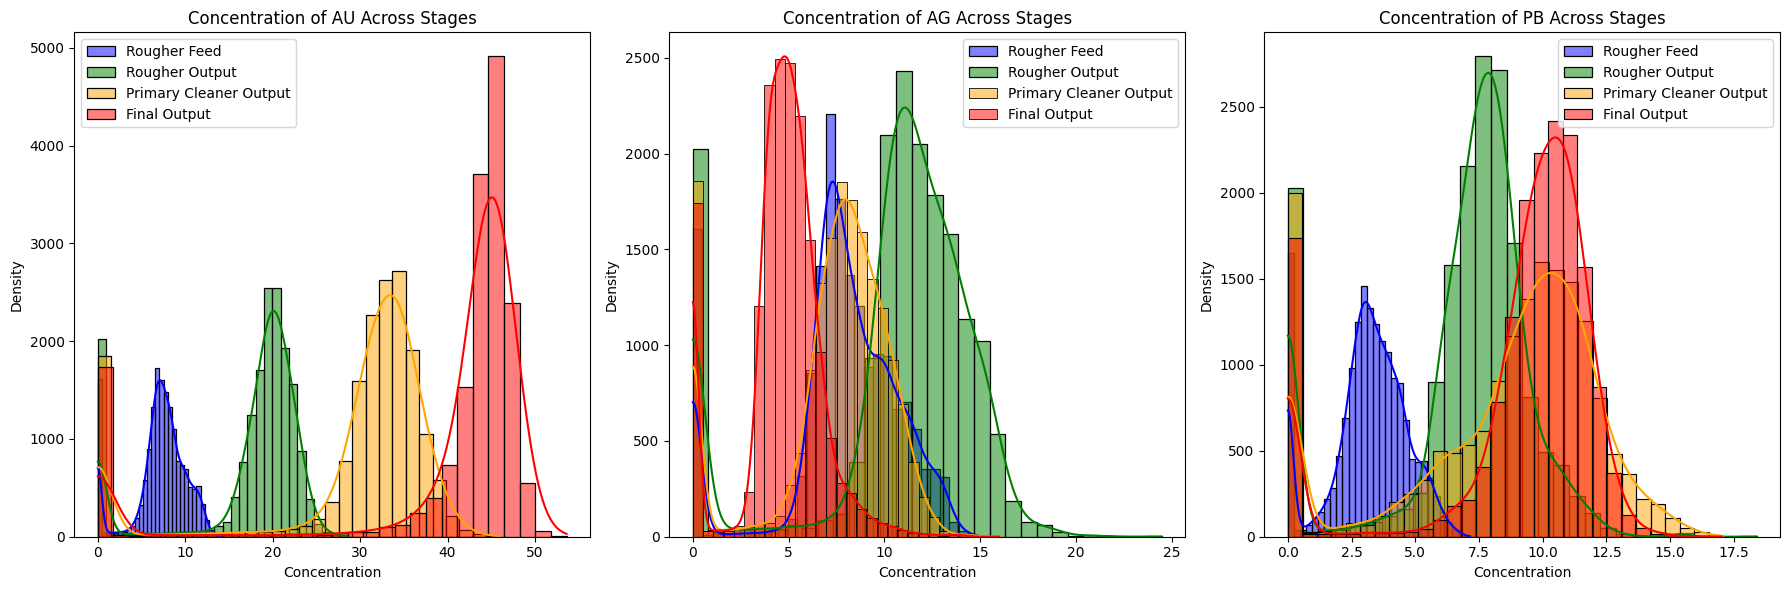

In [7]:
#Calculate the concentration of each mineral at each stage of the process
#primary_cleaner.output.concentrate_au/ag/pb   vs. #final.output.concentrate_au/ag/pb vs rougher.input vs rougher.output
import matplotlib.pyplot as plt
import seaborn as sns

metals = ['au', 'ag', 'pb']

stages = {
    'Rougher Feed': 'rougher.input.feed_{}',
    'Rougher Output': 'rougher.output.concentrate_{}',
    'Primary Cleaner Output': 'primary_cleaner.output.concentrate_{}',
    'Final Output': 'final.output.concentrate_{}'
}

stage_colors = {
    'Rougher Feed': 'blue',
    'Rougher Output': 'green',
    'Primary Cleaner Output': 'orange',
    'Final Output': 'red'
}

plt.figure(figsize=(18, 6))

for i, metal in enumerate(metals, 1):
    plt.subplot(1, 3, i)
    
    for stage_name, stage_col in stages.items():
        col_name = stage_col.format(metal)
        if col_name in train.columns:
            sns.histplot(train[col_name], label=stage_name, kde=True, bins=30, 
                         alpha=0.5, color=stage_colors[stage_name])  

    plt.title(f"Concentration of {metal.upper()} Across Stages")
    plt.xlabel("Concentration")
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()  
plt.show()

#The concentration of gold increases from the first stage of purification to the final.  The goal is to extract as much gold as possible while excluding the other minerals so it makes sense we are seeing an increase in the gold amounts while the other two minerals have decreased concnetrations or stay relatively flat.  Ag (Silver) decreases slightly in concentration through each stage of the process while Pb (lead) increased slightly from the rougher feed to rougher output and again slightly to the primary cleaner output stage.  Its important to note there is a large amount of 0 values in each stage of the process for all of the metals.

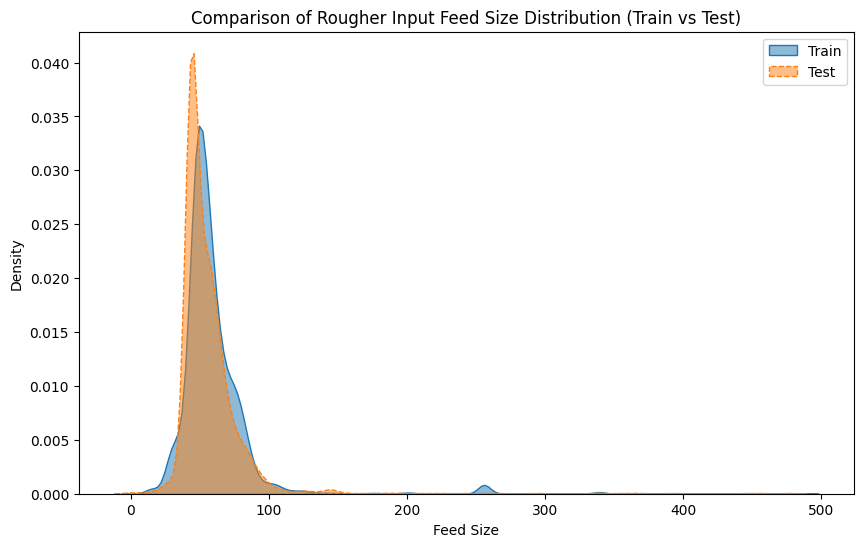

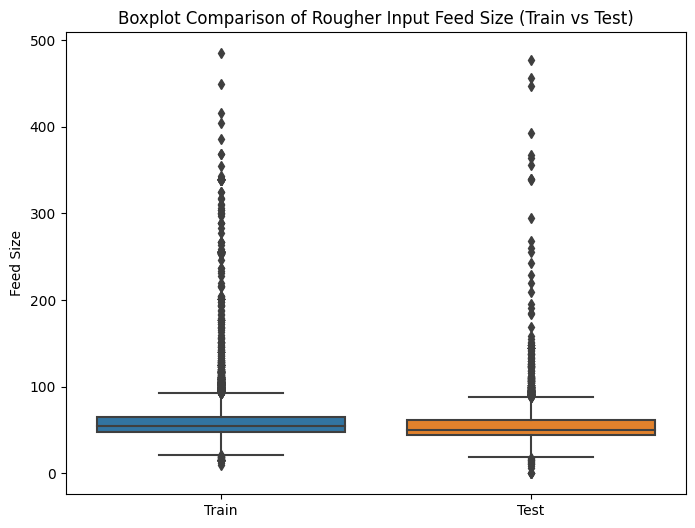

Train Dataset - Feed Size Statistics:
 count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Test Dataset - Feed Size Statistics:
 count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


In [8]:
#Calculate distributions of feed particle size between test set and training set
#rougher.input.feed_size
plt.figure(figsize=(10, 6))
sns.kdeplot(train["rougher.input.feed_size"], label="Train", fill=True, alpha=0.5)
sns.kdeplot(test["rougher.input.feed_size"], label="Test", fill=True, alpha=0.5, linestyle="dashed")

plt.title("Comparison of Rougher Input Feed Size Distribution (Train vs Test)")
plt.xlabel("Feed Size")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=[train["rougher.input.feed_size"], test["rougher.input.feed_size"]], orient="v")
plt.xticks(ticks=[0, 1], labels=["Train", "Test"])
plt.title("Boxplot Comparison of Rougher Input Feed Size (Train vs Test)")
plt.ylabel("Feed Size")
plt.show()

train_stats = train["rougher.input.feed_size"].describe()
test_stats = test["rougher.input.feed_size"].describe()

print("Train Dataset - Feed Size Statistics:\n", train_stats)
print("\nTest Dataset - Feed Size Statistics:\n", test_stats)

#The distributions are very similar with most of the data around the 40 to 70 range and large outliers of high feed size variables causing negative skew.

#Next we need to take a look at total concentrations of each substance at each stage of the process.(raw feed, rougher concentrate, final concentrate)

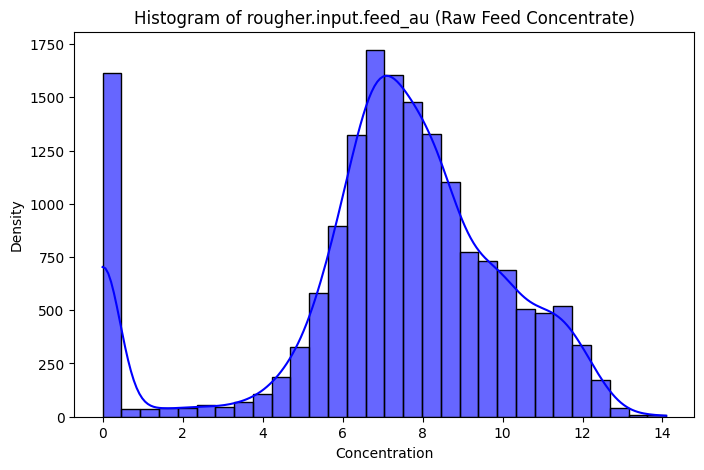

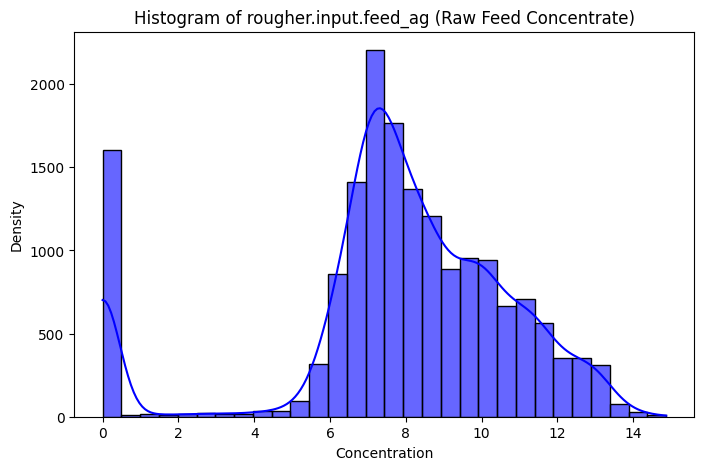

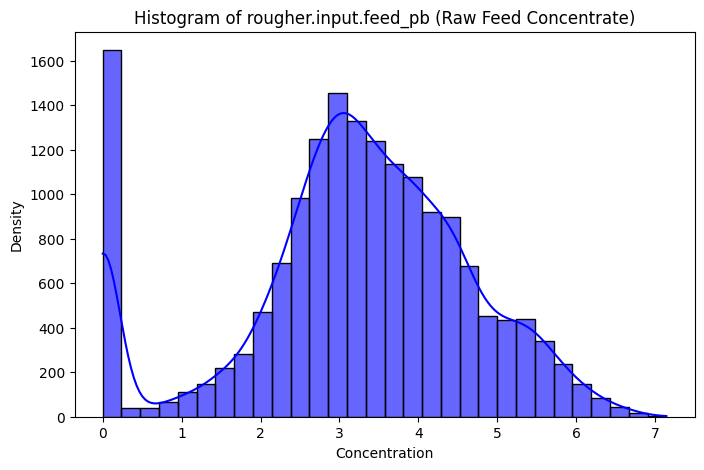

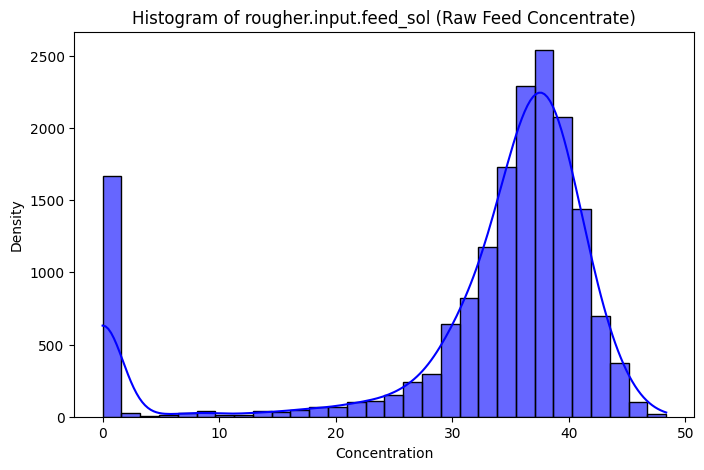

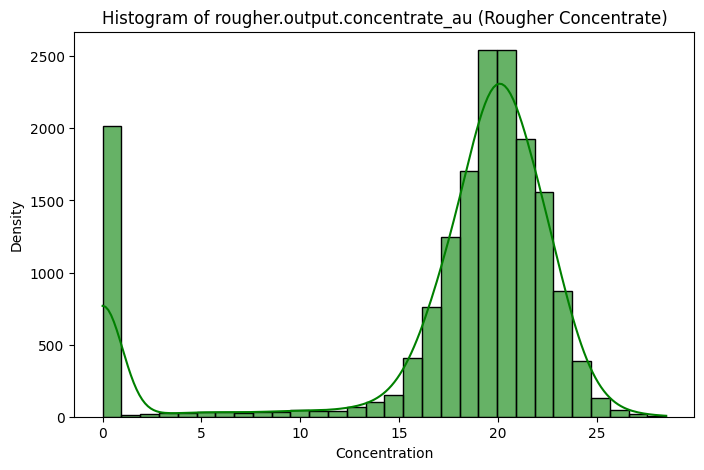

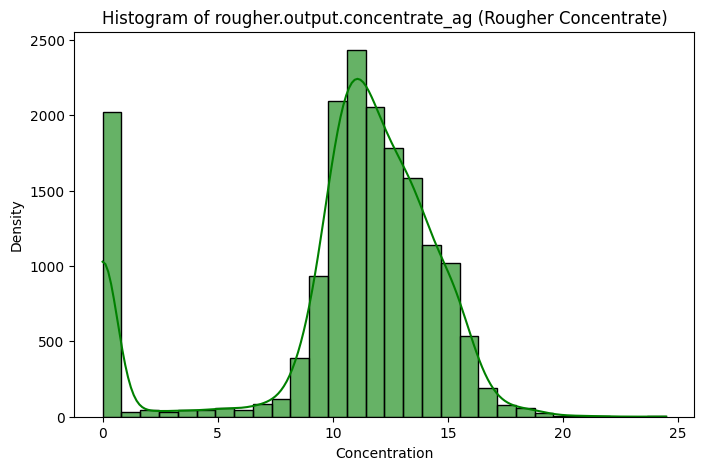

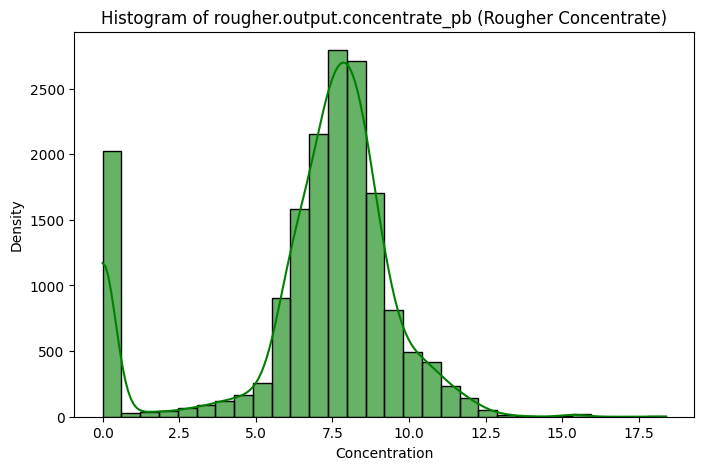

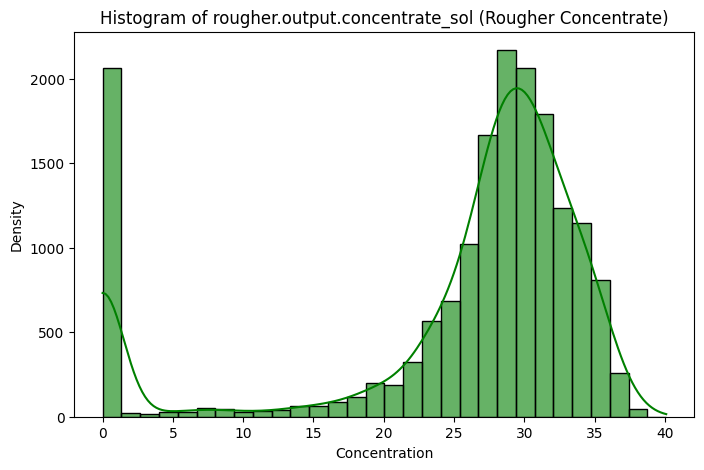

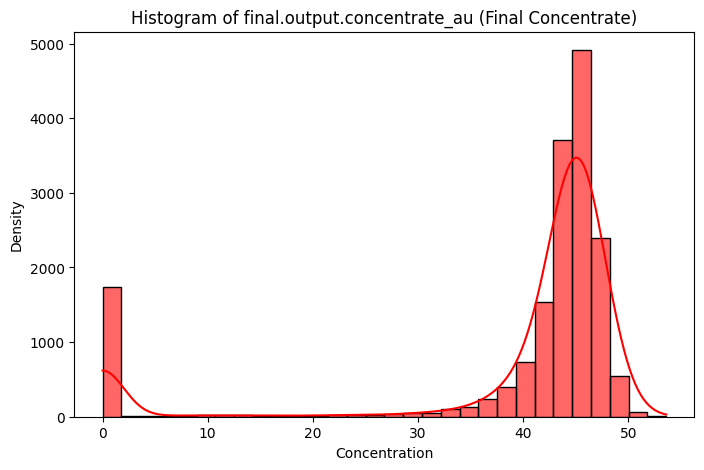

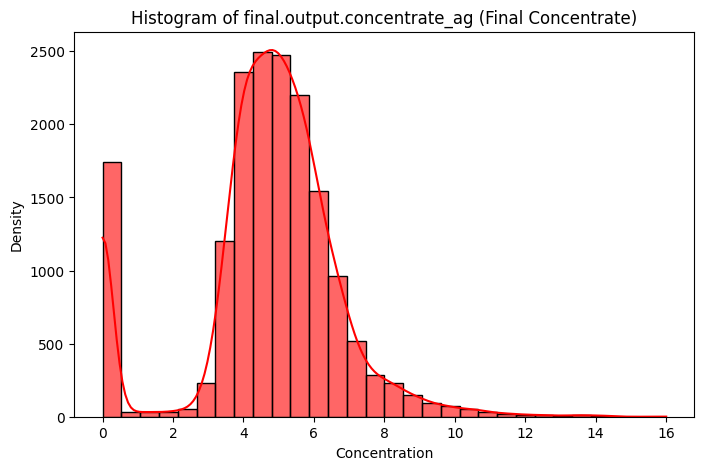

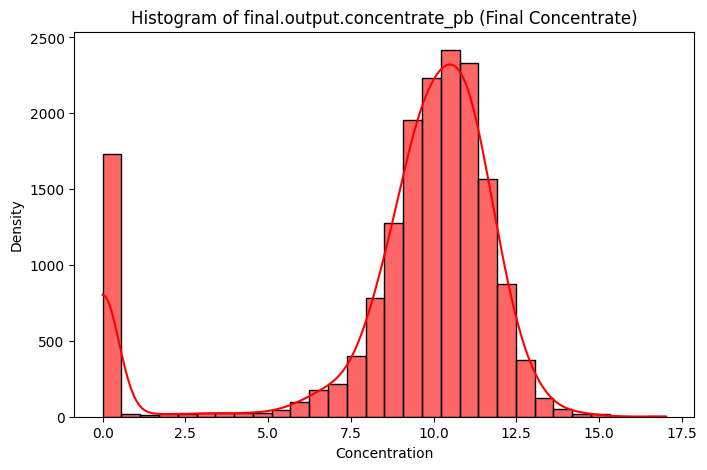

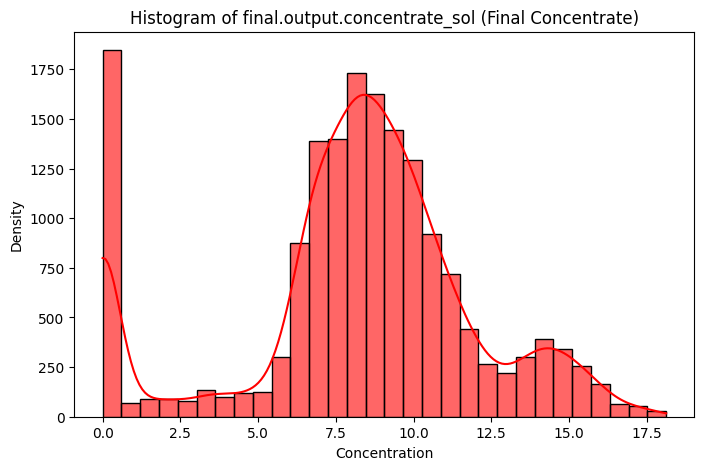

In [9]:
raw_feed_concentrate = [ 'rougher.input.feed_au', 
    'rougher.input.feed_ag', 
    'rougher.input.feed_pb',
    'rougher.input.feed_sol'
]

rougher_concentrate = [ 'rougher.output.concentrate_au', 
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol'
]

final_concentrate = [
    'final.output.concentrate_au', 
    'final.output.concentrate_ag', 
    'final.output.concentrate_pb',
    'final.output.concentrate_sol'
]

raw_feed_concentrate_data = train[raw_feed_concentrate]
rougher_concentrate_data = train[rougher_concentrate]
final_concentrate_data = train[final_concentrate]


for col in raw_feed_concentrate:
    plt.figure(figsize=(8, 5))
    sns.histplot(train[col], bins=30, kde=True, color='blue', alpha=0.6)
    plt.title(f"Histogram of {col} (Raw Feed Concentrate)")
    plt.xlabel("Concentration")
    plt.ylabel("Density")
    plt.show()


for col in rougher_concentrate:
    plt.figure(figsize=(8, 5))
    sns.histplot(train[col], bins=30, kde=True, color='green', alpha=0.6)
    plt.title(f"Histogram of {col} (Rougher Concentrate)")
    plt.xlabel("Concentration")
    plt.ylabel("Density")
    plt.show()

for col in final_concentrate:
    plt.figure(figsize=(8, 5))
    sns.histplot(train[col], bins=30, kde=True, color='red', alpha=0.6)
    plt.title(f"Histogram of {col} (Final Concentrate)")
    plt.xlabel("Concentration")
    plt.ylabel("Density")
    plt.show()



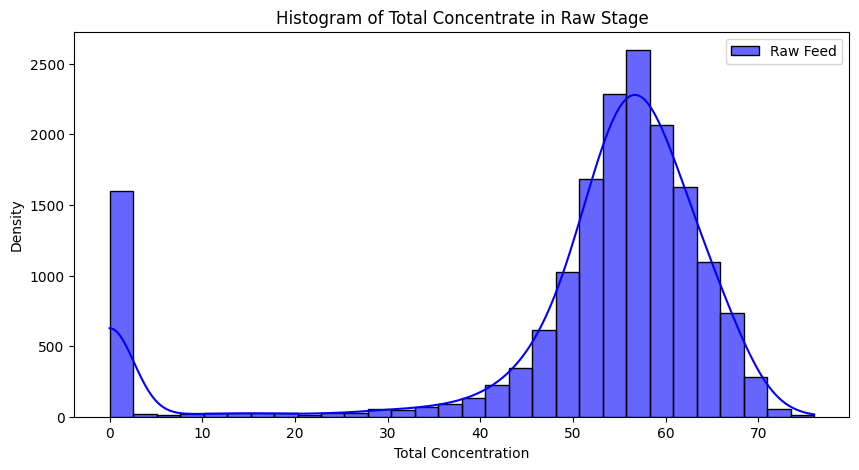

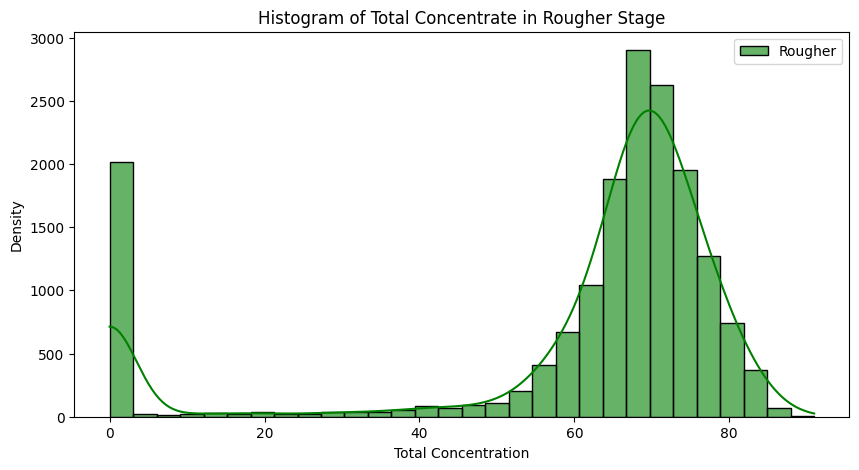

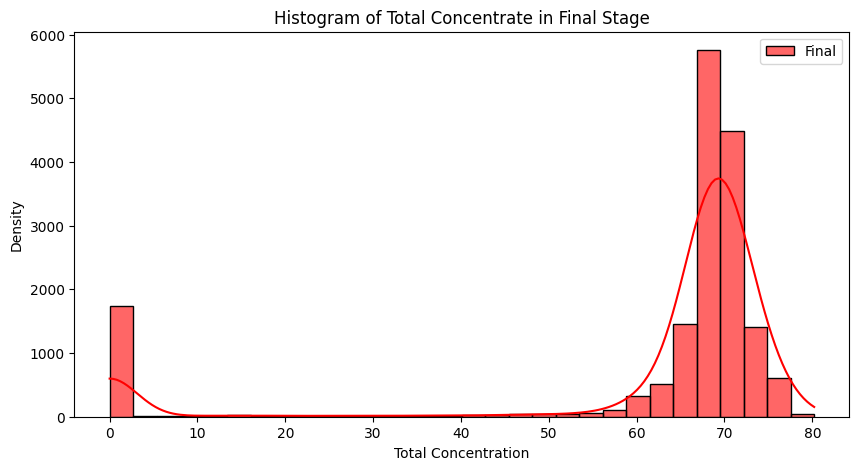

In [10]:
train["total_raw_feed_concentrate"] = train[raw_feed_concentrate].sum(axis=1)
train["total_rougher_concentrate"] = train[rougher_concentrate].sum(axis=1)
train["total_final_concentrate"] = train[final_concentrate].sum(axis=1)


# Plot histograms for total concentrate values
plt.figure(figsize=(10, 5))
sns.histplot(train["total_raw_feed_concentrate"], bins=30, kde=True, color='blue', alpha=0.6, label="Raw Feed")
plt.title("Histogram of Total Concentrate in Raw Stage")
plt.xlabel("Total Concentration")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(train["total_rougher_concentrate"], bins=30, kde=True, color='green', alpha=0.6, label="Rougher")
plt.title("Histogram of Total Concentrate in Rougher Stage")
plt.xlabel("Total Concentration")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(train["total_final_concentrate"], bins=30, kde=True, color='red', alpha=0.6, label="Final")
plt.title("Histogram of Total Concentrate in Final Stage")
plt.xlabel("Total Concentration")
plt.ylabel("Density")
plt.legend()
plt.show()



#Looking at the data there appears to be a large amount of 0 values in all the data that is going to drag down averages and make it hard for regression models to predict the information.  It is tough to know if the 0's are true values or missing values but I am going to assume they are areas where we are missing information so I am going to change them to the mean.  Also from looking the data the dispersion of total concentration gets smaller after each stage and more values cumulate around the mean.

In [11]:
print(train["total_final_concentrate"].describe())

count    16860.000000
mean        61.267542
std         21.690164
min          0.000000
25%         66.531283
50%         68.803475
75%         70.695552
max         80.210644
Name: total_final_concentrate, dtype: float64


In [12]:
train = train.loc[~(train[raw_feed_concentrate + rougher_concentrate + final_concentrate] < 1).any(axis=1)]


print(train["total_final_concentrate"].describe())

count    14216.000000
mean        68.690382
std          5.392174
min          9.163560
25%         67.569617
50%         69.162388
75%         70.974073
max         80.210644
Name: total_final_concentrate, dtype: float64


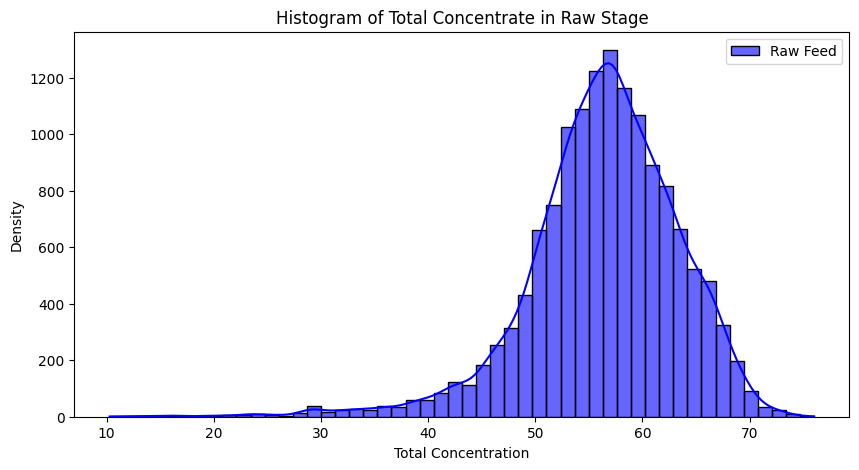

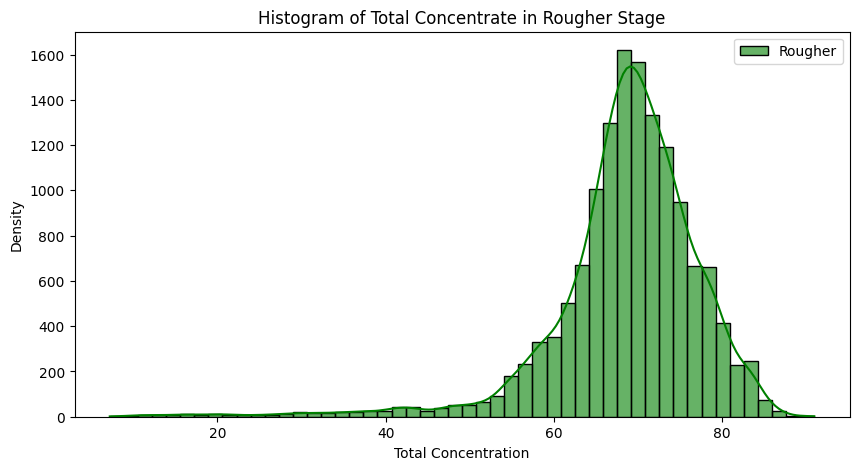

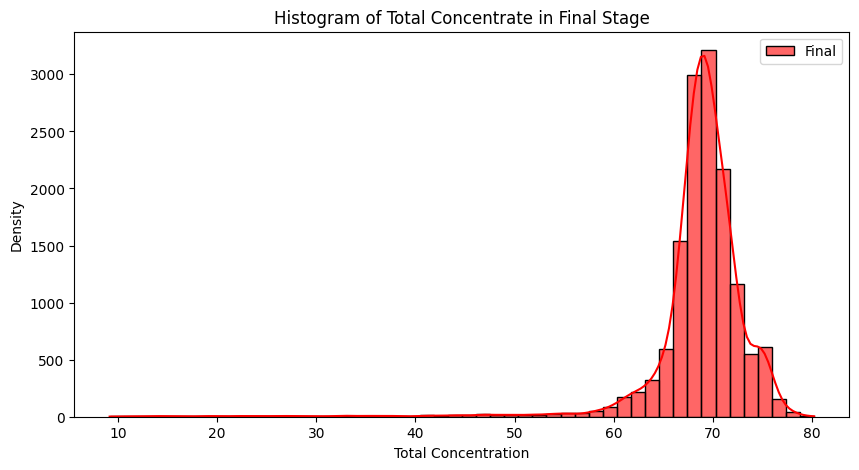

In [13]:
train["total_raw_feed_concentrate"] = train[raw_feed_concentrate].sum(axis=1)
train["total_rougher_concentrate"] = train[rougher_concentrate].sum(axis=1)
train["total_final_concentrate"] = train[final_concentrate].sum(axis=1)

columns_to_check = raw_feed_concentrate + rougher_concentrate + final_concentrate

plt.figure(figsize=(10, 5))
sns.histplot(train["total_raw_feed_concentrate"], bins=50, kde=True, color='blue', alpha=0.6, label="Raw Feed")
plt.title("Histogram of Total Concentrate in Raw Stage")
plt.xlabel("Total Concentration")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(train["total_rougher_concentrate"], bins=50, kde=True, color='green', alpha=0.6, label="Rougher")
plt.title("Histogram of Total Concentrate in Rougher Stage")
plt.xlabel("Total Concentration")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(train["total_final_concentrate"], bins=50, kde=True, color='red', alpha=0.6, label="Final")
plt.title("Histogram of Total Concentrate in Final Stage")
plt.xlabel("Total Concentration")
plt.ylabel("Density")
plt.legend()
plt.show()



#Based off there be a large number of 0s in all points of the data I decided to drop any value less than 0.1 of total concentration.  Since its is impossible or highly unlikely for the value of the total concentration to be that low.

In [14]:
excluded_columns = {'final.output.recovery', 'rougher.output.recovery'}
columns_to_remove = ['total_raw_feed_concentrate', 'total_rougher_concentrate', 'total_final_concentrate']
missing_columns.extend(columns_to_remove)
missing_columns = [col for col in missing_columns if col not in excluded_columns]


features = train.drop(columns=missing_columns)
full['date'] = pd.to_datetime(full['date'])
test['date'] = pd.to_datetime(test['date'])
features['date'] = pd.to_datetime(features['date'])
features['year'] = features['date'].dt.year
features['month'] = features['date'].dt.month
features['day'] = features['date'].dt.day
features['weekday'] = features['date'].dt.weekday

# Now drop the original date column
features = features.drop(columns=['date', 'final.output.recovery', 'rougher.output.recovery'])
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']

features_train, features_valid, target_rougher_train, target_rougher_valid, target_final_train, target_final_valid = train_test_split(
    features, target_rougher, target_final, test_size=0.2, random_state=12345)

print(features.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14216 entries, 0 to 16859
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               14216 non-null  float64
 1   primary_cleaner.input.depressant            14216 non-null  float64
 2   primary_cleaner.input.feed_size             14216 non-null  float64
 3   primary_cleaner.input.xanthate              14216 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      14216 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    14216 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      14216 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    14216 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      14216 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    14216 non-null  float64
 10  primary_cl

In [15]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value  # SMAPE formula

smape_scorer = make_scorer(smape, greater_is_better=False)  # Lower SMAPE is better


param_grid = {
    'n_estimators': [2, 10, 20],  # Number of trees
    'min_samples_split': [2, 5, 10]  # Minimum number of samples to split a node
}

rf_model = RandomForestRegressor(random_state=12345, n_jobs=-1)


grid_search_rougher = GridSearchCV(rf_model, param_grid, scoring=smape_scorer, cv=3, n_jobs=-1)
grid_search_rougher.fit(features, target_rougher)


grid_search_final = GridSearchCV(rf_model, param_grid, scoring=smape_scorer, cv=3, n_jobs=-1)
grid_search_final.fit(features, target_final)

print(f"Best Parameters for Rougher Recovery Model: {grid_search_rougher.best_params_}")
print(f"Best Parameters for Final Recovery Model: {grid_search_final.best_params_}")

best_model_rougher = grid_search_rougher.best_estimator_
best_model_final = grid_search_final.best_estimator_

cv_scores_rougher = cross_val_score(best_model_rougher, features, target_rougher, scoring=smape_scorer, cv=3, n_jobs=-1)
cv_scores_final = cross_val_score(best_model_final, features, target_final, scoring=smape_scorer, cv=3, n_jobs=-1)

best_smape_rougher = -1 * np.mean(cv_scores_rougher)
best_smape_final = -1 * np.mean(cv_scores_final)

print(f"Best SMAPE Score for Rougher Recovery: {best_smape_rougher:.4f}")
print(f"Best SMAPE Score for Final Recovery: {best_smape_final:.4f}")

Best Parameters for Rougher Recovery Model: {'min_samples_split': 5, 'n_estimators': 20}
Best Parameters for Final Recovery Model: {'min_samples_split': 5, 'n_estimators': 20}
Best SMAPE Score for Rougher Recovery: 8.5169
Best SMAPE Score for Final Recovery: 11.8158


In [28]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

smape_scorer = make_scorer(smape, greater_is_better=False) 

model_lr = LinearRegression()

cv_scores_rougher = cross_val_score(model_lr, features, target_rougher, scoring=smape_scorer, cv=10)
cv_scores_final = cross_val_score(model_lr, features, target_final, scoring=smape_scorer, cv=10)

rougher_score_lr = -1 * np.mean(cv_scores_rougher)
final_score_lr = -1 * np.mean(cv_scores_final)

print('Average Linear Regression rougher model SMAPE score:', rougher_score_lr)
print('Average Linear Regression final model SMAPE score:', final_score_lr)
print('Combined Linear Regression SMAPE score:', ((0.25 * rougher_score_lr) + (0.75 * final_score_lr)))

Average Linear Regression rougher model SMAPE score: 6.456106156490345
Average Linear Regression final model SMAPE score: 10.135618860219594
Combined Linear Regression SMAPE score: 9.215740684287281


In [17]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(max_depth=20, random_state=12345)

cv_scores_rougher = cross_val_score(model_dt, features, target_rougher, scoring=smape_scorer, cv=10, n_jobs=-1)
cv_scores_final = cross_val_score(model_dt, features, target_final, scoring=smape_scorer, cv=10, n_jobs=-1)

rougher_score_dt = -1 * np.mean(cv_scores_rougher)
final_score_dt = -1 * np.mean(cv_scores_final)

print('Average Decision Tree Regression rougher model SMAPE score:', rougher_score_dt)
print('Average Decision Tree Regression final model SMAPE score:', final_score_dt)
print('Combined Decision Tree Regression SMAPE score:', ((0.25 * rougher_score_dt) + (0.75 * final_score_dt)))

Average Decision Tree Regression rougher model SMAPE score: 13.711751084138879
Average Decision Tree Regression final model SMAPE score: 14.94795349027147
Combined Decision Tree Regression SMAPE score: 14.638902888738322


In [18]:
full['date'] = pd.to_datetime(full['date'])
test['date'] = pd.to_datetime(test['date'])
print(test.info())
print(features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64       
 9   primary_

Based on all the models the linear regression model performed the best on the data with a combined sMAPE score of 15.54.  Therefore I will be using that model for the test data.  First I have to clean the test data and get it to match the features data from before.  I am going to do that by merging rougher and final output recovery from the full dataset onto the test data.  From there I will check if any columns are still missing.  Then I will convert date to datetime data points to match the features dates.

In [19]:
test = test.merge(
    full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

features_columns = set(features.columns)
test_columns = set(test.columns)

missing_columns_2 = features_columns - test_columns

print("Columns in Features but Missing in Test:")
print(missing_columns_2)

print(test.info())

Columns in Features but Missing in Test:
{'year', 'weekday', 'day', 'month'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cle

In [20]:
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday

In [21]:
features_columns = set(features.columns)
test_columns = set(test.columns)

missing_columns_2 = features_columns - test_columns

print("Columns in Features but Missing in Test:")
print(missing_columns_2)

test = test.drop(columns=['date'])
print(test.info())

Columns in Features but Missing in Test:
set()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 58 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5856 non-null   float64
 1   primary_cleaner.input.depressant            5856 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5856 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_lev

In [22]:
features_test = test.drop(columns=['rougher.output.recovery', 'final.output.recovery'])
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
print(features_scaled_df.info())
print(features_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14216 entries, 0 to 14215
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               14216 non-null  float64
 1   primary_cleaner.input.depressant            14216 non-null  float64
 2   primary_cleaner.input.feed_size             14216 non-null  float64
 3   primary_cleaner.input.xanthate              14216 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      14216 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    14216 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      14216 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    14216 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      14216 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    14216 non-null  float64
 10  primary_cl

In [29]:
model_lr = LinearRegression()

model_lr.fit(features, target_rougher)
pred_rougher_test = model_lr.predict(features_test)

model_lr.fit(features, target_final)
pred_final_test = model_lr.predict(features_test)  

smape_rougher_test = smape(target_rougher_test, pred_rougher_test)
smape_final_test = smape(target_final_test, pred_final_test)

combined_smape_test = (0.25 * smape_rougher_test) + (0.75 * smape_final_test)

print('Average Linear Regression rougher model SMAPE score:', smape_rougher_test)
print('Average Linear Regression final model SMAPE score:', smape_final_test)
print('Combined Linear Regression SMAPE score:', combined_smape_test)

Average Linear Regression rougher model SMAPE score: 9.831530989552787
Average Linear Regression final model SMAPE score: 12.4607100632553
Combined Linear Regression SMAPE score: 11.803415294829673


I sliced up the test data to the features and target variables than ran the model on the test data.  The sMAPE score we got was 11.63 which was a slight improvement from the orginal linear regression test.

In [24]:
from sklearn.dummy import DummyRegressor
dummy_regr_rougher = DummyRegressor(strategy="mean")
dummy_regr_final = DummyRegressor(strategy="mean")

dummy_regr_rougher.fit(features, target_rougher)
dummy_regr_final.fit(features, target_final)

pred_rougher = dummy_regr_rougher.predict(features)
pred_final = dummy_regr_final.predict(features)

smape_rougher = smape(target_rougher, pred_rougher)
smape_final = smape(target_final, pred_final)


print(f"Dummy Regressor SMAPE for Constant Rougher Recovery: {smape_rougher:.4f}")
print(f"Dummy Regressor SMAPE for Constant Final Recovery: {smape_final:.4f}")
print(f"Combined Dummy Model SMAPE Score: {(0.25 * smape_rougher) + (0.75 * smape_final):.4f}")

Dummy Regressor SMAPE for Constant Rougher Recovery: 7.7039
Dummy Regressor SMAPE for Constant Final Recovery: 10.1921
Combined Dummy Model SMAPE Score: 9.5701


#Combined dummy score came out at 9.57 which is slightly worse than what the original training data's smape score came out as.  It is also better than what the test data sMAPE score came out as 11.8.  The linear regression model still was the best out of all the models though.  Running GridSearch for Random Forest did not get us any better scores and neither did putting a few parameters in the Decision Tree model.  

#Overall the information was very confusing or complex at first but we simplified it by scanning the data for areas that did not make sense.  For example rows with 0 values we ended up dropping and we combined some of the output metrics to get an idea of how the total concentration changed throughout the whole process.  Finally when we got to modeling the data we used three different models.  Linear Regression, Decision Tree and Random Forest.  Calculating the smape scores from the predicted values of the model led to the linear regression model being the best sMAPE score for the data.